Probability and Random Processes Assignment 3.
 
Real Time Tracking Using Gaussian Mixtures to Model Background.


In [1]:
#importing required Libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from numba import cuda
import matplotlib as mpl
from google.colab.patches import cv2_imshow
from numpy.linalg import norm, inv

In [2]:
path = '/content/GaussianMixtureModelling_data_traffic.avi' #path of video to be used

Below are various functions that are used. The functions to reduce_resolution and increase_resolution were added to scale down an image for faster running of code.

In [3]:
#various utility functions
def mv_norm(x, mu, sigma):
  return (1/np.sqrt(np.linalg.det(sigma)))*np.exp(-0.5*np.matmul(np.matmul((x-mu).T, np.linalg.inv(sigma)), (x-mu)))
def reduce_resolution(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv.resize(image, dim, interpolation = cv.INTER_AREA)
    return resized
def increase_resolution(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv.resize(image, dim, interpolation = cv.INTER_AREA)
    return resized
def extract_frames_reduce_resolution(path,scale):
  frames_array = []
  video = cv.VideoCapture(path)
  while(1):
    ret, frame = video.read()
    if (ret == False):
      break
    frames_array.append(reduce_resolution(frame,scale))
  return frames_array
def check_distance(x, mu, sigma):
  d = np.sqrt(np.matmul(np.matmul((x-mu).T, np.linalg.inv(sigma)), (x-mu)))  #This is the Mahalanobis distance (in 3 colors space , trivariate)
  if d < 2.5:
    return True
  else:
    return False

In [4]:
#function to reorder weights to know background components
def reorder_weights(weight, sigma, means, B, K, T):  #B is the number of background components in each pixel.
  h, w = weight.shape[:2] #get height and width of image
  for i in range(h):    #loop through height
    for j in range(w): #loop throu gh width
      k_weight = weight[i][j]  #get weight of each pixel
      k_norm = np.array([norm(np.sqrt(sigma[i][j][k])) for k in range(K)]) #get norm of each pixel
      ratio = k_weight/k_norm #get ratio of each pixel
      descending_order = np.argsort(-ratio) #sort in descending order

      weight[i][j] = weight[i][j][descending_order] #reorder weights
      means[i][j] = means[i][j][descending_order] #reorder means
      sigma[i][j] = sigma[i][j][descending_order] #reorder sigma
      cum_weight = 0 #initialize cumulative weight
      for index, order in enumerate(descending_order): #loop through descending order
        cum_weight += weight[i][j][index] #add weight to cumulative weight
        if (cum_weight > T ): #if cumulative weight is greater than threshold
          B[i][j] = index + 1 #set background to index + 1
          break
  return weight, sigma, means, B

In [5]:
def background_model(frames,a,training_frames): #function to train the background model and return appropriate weights and parameters
  #a is learning rate
  #frames is a list of video frames passed to the function
  #training_frames is the number of frames we wish to train the model on
  K = 4                                     #K is the number of Gaussians we wish to use to model each pixel = 4
  print('Size of image',frames[0].shape[0:2])#prints the size of video
  h,w = frames[0].shape[0:2]                #height and width of video
  T = len(frames)                           #number of frames in the video
  init_weight = [0.6, 0.1, 0.2, 0.1]        #initial weights of the Gaussians
  init_u = np.zeros(3)                      #Initial mean for each Gaussian. This is a 3x1 vector 
  init_sigma = 225*np.eye(3)                #Initial covariance matrix for each Gaussian. This is a 3x3 diagonal matrix  
  img_init = frames[0]                      #first frame of the video 
  #create a matrix for weights, means and covariances for each pixel
  weight = np.array([[init_weight for j in range(w)] for i in range(h)])                    # 3D array of size h x w x 4 
  means = np.zeros((h, w, K, 3), dtype=float)                                            # 4D array of size h x w x 4 x 3
  sigma = np.array([[[init_sigma for k in range(K)] for j in range(w)] for i in range(h)])  # 4D array of size h x w x 4 x 3 x 3

  B = np.ones((h,w), dtype=int)               #background matrix of size h x w initialized to 1 (all pixels are background) 
  for k in range(K):
    means[:,:,k,:] = img_init 
  for t in range(training_frames):            #loop through frames to train
    frame = frames[t]                         #current frame
    print('processing frame ',t+1)              #current processing frame indicator
    for i in range(h):                        #loop through all rows
      for j in range(w):                      #loop through all columns
        match = -1                            #match is the index of the Gaussian that matches the current pixel. Set to -1 , assuming no match at the start
        for k in range(K):                    #loop through all Gaussians
          if check_distance(frame[i][j], means[i][j][k], sigma[i][j][k]): #check if the current pixel matches the current Gaussian
            match = k                         #if it matches, set match to the index of the Gaussian
            break                             #break out of the loop
        if match != -1:                       #if a match is found update all parameters in accordance to the equations in reasearch paper
          x = frame[i][j].astype(float)                                     #current pixel
          delta = x - means[i][j][match]                                    #difference between current pixel and mean of Gaussian
          rho = a*mv_norm(x, means[i][j][match], sigma[i][j][match])        #calculate rho
          weight[i][j] = (1-a)*weight[i][j]                                 #update weight of Gaussian
          weight[i][j][match] = weight[i][j][match] + a                     #update weight of Gaussian
          means[i][j][match] = means[i][j][match] + rho*delta               #update mean of Gaussian
          sigma[i][j][k] = sigma[i][j][match] + rho * (np.matmul(delta, delta.T) - sigma[i][j][match]) #update covariance matrix of Gaussian
          # if none of the K distributions match the current value the least probable distribution is replaced with a distribution with current value as its mean, an initially high variance and low weight
        if match == -1:                                         #if no match found
          w_list = [weight[i][j][k] for k in range(K)]          #list of weights of all Gaussians
          id = w_list.index(min(w_list))                        #index of the Gaussian with the least weight
          means[i][j][id] = np.array(frame[i][j]).reshape(1, 3) #set the mean of the Gaussian to the current pixel, weight is kept same
          sigma[i][j][id] = np.array(init_sigma)                #set the covariance matrix of the Gaussian to the initial covariance matrix
    weight, sigma, means, B = reorder_weights(weight, sigma, means, B, K, T = 0.7) #rearrange weights and decide which gaussians constitute the background
  return weight, sigma, means, B

In [6]:
def create_mask(frame,weight, sigma, means, B): #function to create mask 
    output_image = np.array(frame) #create a copy of the frame
    h,w = frame.shape[0:2] #height and width of frame
    K = 4 #number of Gaussians
    for i in range(h): #loop through all rows
        for j in range(w): #loop through all columns
            for k in range(B[i][j]):
                if check_distance(frame[i][j], means[i][j][k], sigma[i][j][k]):
                    output_image[i][j] = 0
                    break
    return output_image

In [7]:
def extract_background_inbuilt(frames):                          #returns an array of frames with background subtracted using inbuilt function for comparison
  fgbg = cv.bgsegm.createBackgroundSubtractorMOG()               #create background subtractor
  frames_foreground = []                                         #array to store foregrounds
  for i in range(len(frames)):
    frame = frames[i]                                            #loop through frames
    foreground = fgbg.apply(frame)                               #apply background subtractor
    frames_foreground.append(foreground)                         #add foreground to array
  return(frames_foreground)                                      #return array of foregrounds

In [8]:
#Training the model
scale_factor = 75
training_frames = 25
learning_rate = 0.1
inverse_scale_factor = (100/scale_factor)*100
frames = extract_frames_reduce_resolution(path,scale_factor)
weight, sigma, means, B = background_model(frames,learning_rate,training_frames)
frames_reference = extract_background_inbuilt(frames) #getting background detection on all frames using inbuilt function for reference

Size of image (90, 120)
processing frame  1
processing frame  2
processing frame  3
processing frame  4
processing frame  5
processing frame  6
processing frame  7
processing frame  8
processing frame  9
processing frame  10
processing frame  11
processing frame  12
processing frame  13
processing frame  14
processing frame  15
processing frame  16
processing frame  17
processing frame  18
processing frame  19
processing frame  20
processing frame  21
processing frame  22
processing frame  23
processing frame  24
processing frame  25


In [9]:
#getting images for testing and refernce
def create_test(id,frames,weight,sigma,means,B,frames_reference):
  img1 = frames[id]
  img1_masked = create_mask(img1,weight, sigma, means, B)
  reference_image = frames_reference[id]
  return img1 , img1_masked , reference_image
#Checking the background subtraction on a specific image
def test(means,img1,img1_masked,reference_image):
  print('Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is')
  cv2_imshow(increase_resolution(means[:,:,0,:],inverse_scale_factor))
  print('Original Image (scaled down) with image id ', id)
  cv2_imshow(increase_resolution(img1,inverse_scale_factor))
  print('Background Removed images from written algorithm')
  cv2_imshow(increase_resolution(img1_masked,inverse_scale_factor))
  print('Background Removed images from inbuilt algorithm')
  cv2_imshow(increase_resolution(reference_image,inverse_scale_factor))

In [10]:
#function to compare the percentage of background removed correctly
def compare_images(image, reference_image):
    cv2_imshow 
    ret, image1 = cv.threshold(image, 1, 255, 0)                                    #thresholding the image
    diff = cv.absdiff(cv.cvtColor(image1, cv.COLOR_BGR2GRAY), reference_image)      #finding the difference between the two images
    non_zero_count = cv.countNonZero(diff)                                          #counting the number of non zero elements
    total_pixels = image1.shape[0] * image1.shape[1]                                #total number of pixels
    percentage = ((total_pixels - non_zero_count) / total_pixels) * 100             #percentage of pixels that are equal to 0
    return percentage

In [11]:
#test accuracy for all frames
def test_accuracy(frames,weight,sigma,means,B,frames_reference):
  accuracy = []
  low_accuracy_frames = []
  high_accuracy_frames = []
  for i in range(len(frames)):
    print('processing frame ' , i+1)
    img1 = frames[i]
    img1_masked = create_mask(img1,weight, sigma, means, B)
    reference_image = frames_reference[i]
    current_accuracy = compare_images(img1_masked,reference_image)
    accuracy.append(current_accuracy)
    if (current_accuracy < 90):
      low_accuracy_frames.append(i)
    else:
      high_accuracy_frames.append(i)
  average_accuracy =  sum(accuracy)/len(accuracy) 
  return accuracy , average_accuracy , low_accuracy_frames, high_accuracy_frames   

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


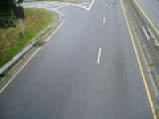

Original Image (scaled down) with image id  115


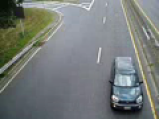

Background Removed images from written algorithm


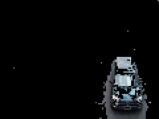

Background Removed images from inbuilt algorithm


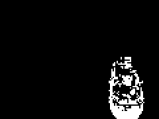

accuracy percentage =  95.7962962962963 %


In [12]:
#Demonstration of algorithm on any given frame
id  = 115
img1 , img1_masked , reference_image = create_test(id,frames,weight,sigma,means,B,frames_reference)
test(means,img1,img1_masked,reference_image)
print('accuracy percentage = ' , compare_images(img1_masked,reference_image),'%')

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


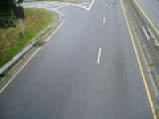

Original Image (scaled down) with image id  0


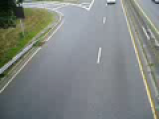

Background Removed images from written algorithm


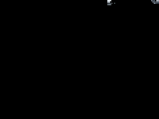

Background Removed images from inbuilt algorithm


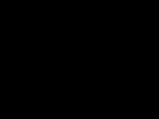

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


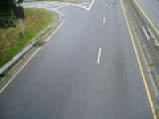

Original Image (scaled down) with image id  6


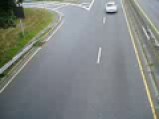

Background Removed images from written algorithm


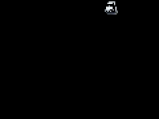

Background Removed images from inbuilt algorithm


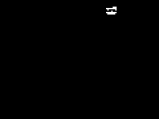

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


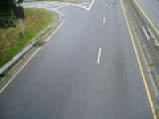

Original Image (scaled down) with image id  12


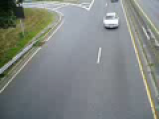

Background Removed images from written algorithm


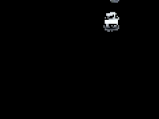

Background Removed images from inbuilt algorithm


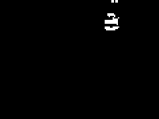

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


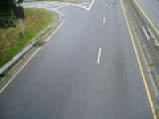

Original Image (scaled down) with image id  18


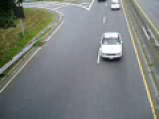

Background Removed images from written algorithm


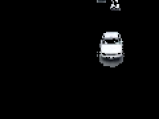

Background Removed images from inbuilt algorithm


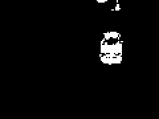

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


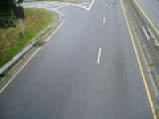

Original Image (scaled down) with image id  24


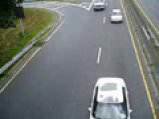

Background Removed images from written algorithm


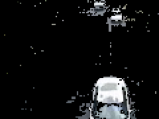

Background Removed images from inbuilt algorithm


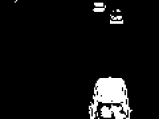

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


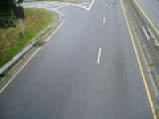

Original Image (scaled down) with image id  30


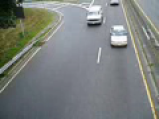

Background Removed images from written algorithm


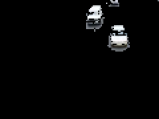

Background Removed images from inbuilt algorithm


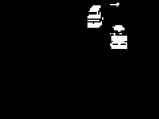

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


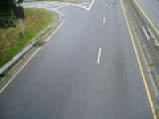

Original Image (scaled down) with image id  36


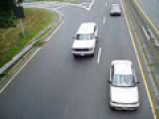

Background Removed images from written algorithm


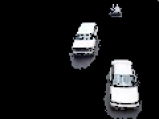

Background Removed images from inbuilt algorithm


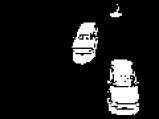

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


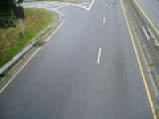

Original Image (scaled down) with image id  42


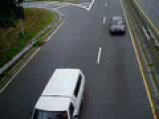

Background Removed images from written algorithm


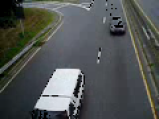

Background Removed images from inbuilt algorithm


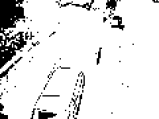

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


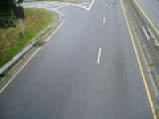

Original Image (scaled down) with image id  48


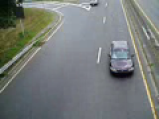

Background Removed images from written algorithm


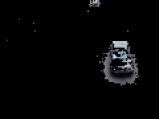

Background Removed images from inbuilt algorithm


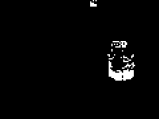

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


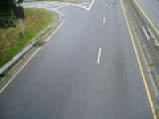

Original Image (scaled down) with image id  54


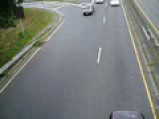

Background Removed images from written algorithm


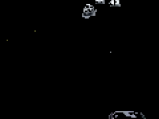

Background Removed images from inbuilt algorithm


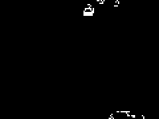

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


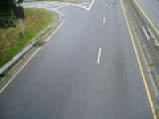

Original Image (scaled down) with image id  60


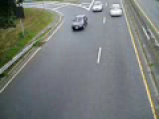

Background Removed images from written algorithm


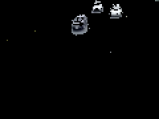

Background Removed images from inbuilt algorithm


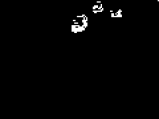

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


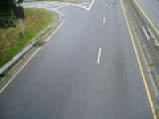

Original Image (scaled down) with image id  66


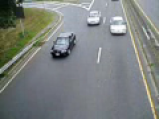

Background Removed images from written algorithm


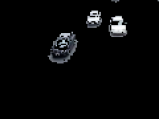

Background Removed images from inbuilt algorithm


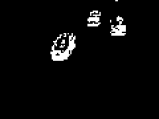

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


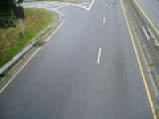

Original Image (scaled down) with image id  72


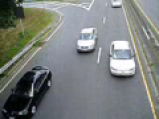

Background Removed images from written algorithm


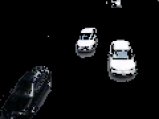

Background Removed images from inbuilt algorithm


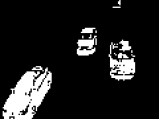

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


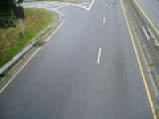

Original Image (scaled down) with image id  78


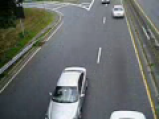

Background Removed images from written algorithm


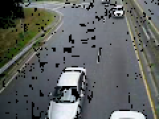

Background Removed images from inbuilt algorithm


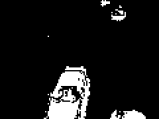

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


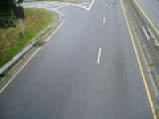

Original Image (scaled down) with image id  84


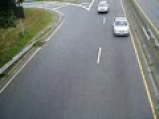

Background Removed images from written algorithm


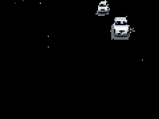

Background Removed images from inbuilt algorithm


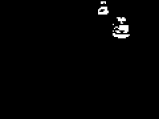

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


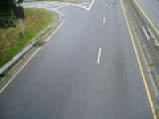

Original Image (scaled down) with image id  90


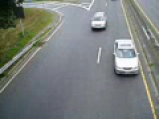

Background Removed images from written algorithm


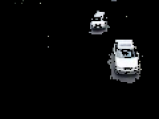

Background Removed images from inbuilt algorithm


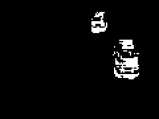

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


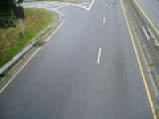

Original Image (scaled down) with image id  96


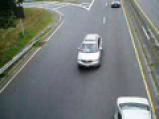

Background Removed images from written algorithm


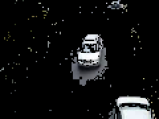

Background Removed images from inbuilt algorithm


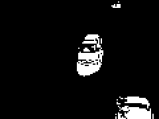

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


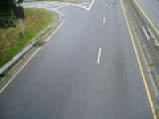

Original Image (scaled down) with image id  102


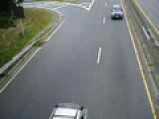

Background Removed images from written algorithm


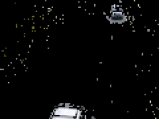

Background Removed images from inbuilt algorithm


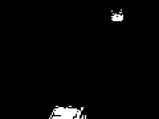

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


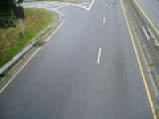

Original Image (scaled down) with image id  108


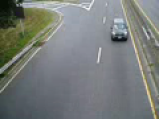

Background Removed images from written algorithm


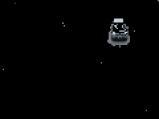

Background Removed images from inbuilt algorithm


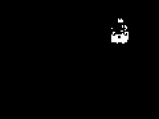

Background model (means) of the gaussian with heighest weight. i.e. this is what the model thinks the background is


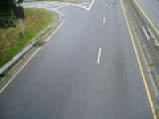

Original Image (scaled down) with image id  114


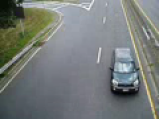

Background Removed images from written algorithm


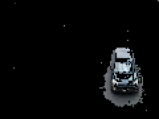

Background Removed images from inbuilt algorithm


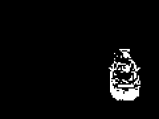

In [13]:
#testing on a larger number of images
for i in range(20):
  id = i*6
  img1 , img1_masked , reference_image = create_test(id,frames,weight,sigma,means,B,frames_reference)
  test(means,img1,img1_masked,reference_image)

In [ ]:
accuracy , average_accuracy , low_accuracy_frames, high_accuracy_frames = test_accuracy(frames,weight,sigma,means,B,frames_reference)


In [ ]:
for i in accuracy: #print all accuracy data
  print("{:.2f}".format(i))

In [15]:
#print average accuracy
print('Average accuracy is', "{:.2f}".format(average_accuracy),'%' )

Average accuracy is 89.46 %


In [16]:
#getting accuracy in low accuracy frames and high accuracy frames
low_accuracy_frames_accuracy = 0
high_accuracy_frames_accuracy = 0
for i in low_accuracy_frames:
    low_accuracy_frames_accuracy = low_accuracy_frames_accuracy + accuracy[i]
print('Accuracy in low accuracy frames = ' , "{:.2f}".format(low_accuracy_frames_accuracy/len(low_accuracy_frames)),'%')
for i in high_accuracy_frames:
    high_accuracy_frames_accuracy = high_accuracy_frames_accuracy + accuracy[i]
print('Accuracy in high accuracy frames = ' , "{:.2f}".format(high_accuracy_frames_accuracy/len(high_accuracy_frames)),'%')

Accuracy in low accuracy frames =  35.98 %
Accuracy in high accuracy frames =  97.69 %


References:
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html

https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566

C. Stauffer and W. E. L. Grimson, "Adaptive background mixture models for real-time tracking," Proceedings. 1999 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (Cat. No PR00149), 1999, pp. 246-252 Vol. 2, doi: 10.1109/CVPR.1999.784637.


Below is some code and functions that can be used for testing and further development

In [ ]:
def play_video_cv(frames, fps):            # function to see video frames using cv2
    for frame in frames:                   # loop through frames
        cv2_imshow(frame)                  # display frame
        cv.waitKey(int(1000/fps))          # pause for 1/fps second

In [ ]:
def extract_frames(path):
  frames_array = []
  video = cv.VideoCapture(path)
  while(1):
    ret, frame = video.read()
    if (ret == False):
      break
    frames_array.append(frame)
  return frames_array

In [ ]:
# some code used at some point to test

cv2_imshow(increase_resolution(means[:,:,0,:],inverse_scale_factor)) 
cv2_imshow(increase_resolution(img1_masked,inverse_scale_factor))
cv2_imshow(increase_resolution(img1,inverse_scale_factor))
cv2_imshow(increase_resolution(img1_m,inverse_scale_factor))
img1_m_gray = cv.cvtColor(img1_m, cv.COLOR_BGR2GRAY)
cv2_imshow(increase_resolution(img1_m_gray,inverse_scale_factor))
ret,img1_BW = cv.threshold(cv.cvtColor(img1_m, cv.COLOR_BGR2GRAY), 1, 255, 0) 
#cv2_imshow(increase_resolution(img1_m[:,:,1],inverse_scale_factor))
cv2_imshow(increase_resolution(img1_BW,inverse_scale_factor))
cv2_imshow(increase_resolution(reference_image,inverse_scale_factor))
#cv2_imshow(increase_resolution(cv.absdiff(img1_BW,reference_image),inverse_scale_factor))

In [ ]:
#checking all frames with low accuracy
print('number of low accuracy frames ' ,len(low_accuracy_frames) )
for i in low_accuracy_frames:
  id = i
  img1 , img1_masked , reference_image = create_test(id,frames,weight,sigma,means,B,frames_reference)
  test(means,img1,img1_masked,reference_image)

In [ ]:
def check_distance_vectorized(x, mu, sigma , B, image): #attempt to vectorize to make code faster
  for k in range(B):
    d = np.sqrt(np.matmul(np.matmul((x-mu).T, np.linalg.inv(sigma)), (x-mu)))  #This is the Mahalanobis distance (in 3 colors space , trivariate)
    if d < 2.5:
        return 0
    else:
        return image
def create_mask_vectorized(frame,weight, sigma, means, B):
    output_image = np.array(frame) #create a copy of the frame
    h,w = frame.shape[0:2] #height and width of frame
    K = 4 #number of Gaussians
    CD = np.vectorize(check_distance_vectorized)
    print(frame.shape,means.shape,sigma.shape,B.shape,output_image.shape)
    output_image = CD(frame, means, sigma, B,output_image)
    return output_image